In [ ]:
# kodları çalıştırmak için her biri farklı transaction yapıyor, tabloyu sıfırlayıp çalıştırını.

In [5]:
import psycopg2

def run_tx_a(i):
    conn = psycopg2.connect(dbname="postgres", user="postgres", password="6054708Fatih", host="localhost")
    conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_READ_COMMITTED)
    cur = conn.cursor()

    cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=%s", (i,))
    e = cur.fetchone()[0]
    cur.execute("UPDATE ACCOUNTS SET balance=%s WHERE accno=%s", (e+1, i))

    cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=0")
    c = cur.fetchone()[0]
    cur.execute("UPDATE ACCOUNTS SET balance=%s WHERE accno=0", (c-1,))

    conn.commit()
    cur.close()
    conn.close()

for i in range(1,101):
    run_tx_a(i)

In [2]:
import threading
import psycopg2

def run_tx_a(i):
    conn = psycopg2.connect(dbname="postgres", user="postgres", password="6054708Fatih", host="localhost")
    conn.set_isolation_level(psycopg2.extensions.ISOLATION_LEVEL_READ_COMMITTED)
    cur = conn.cursor()

    cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=%s", (i,))
    e = cur.fetchone()[0]
    cur.execute("UPDATE ACCOUNTS SET balance=%s WHERE accno=%s", (e+1, i))

    cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=0")
    c = cur.fetchone()[0]
    cur.execute("UPDATE ACCOUNTS SET balance=%s WHERE accno=0", (c-1,))

    conn.commit()
    cur.close()
    conn.close()

for concurrent_tx in range(1, 6):
    threads = []
    for i in range(1, 101):
        t = threading.Thread(target=run_tx_a, args=(i,))
        threads.append(t)
        t.start()
    for t in threads:
        t.join()

In [8]:
import time
import threading
import psycopg2

start_time = time.time()

for concurrent_tx in range(1, 6):
    threads = []
    for i in range(1, 101):
        t = threading.Thread(target=run_tx_a, args=(i,))
        threads.append(t)
        t.start()
    for t in threads:
        t.join()

end_time = time.time()

c1 = None
c2 = None
with psycopg2.connect(dbname="postgres", user="postgres", password="6054708Fatih", host="localhost") as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=0")
        c1 = cur.fetchone()[0]
        for concurrent_tx in range(1, 6):
            threads = []
            for i in range(1, 101):
                t = threading.Thread(target=run_tx_a, args=(i,))
                threads.append(t)
                t.start()
            for t in threads:
                t.join()
        cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=0")
        c2 = cur.fetchone()[0]

c_value = (c1 - c2) / 100
t = end_time - start_time
tps = 100 / t

print("Correctness: ", c_value)
print("Throughput: ", tps, " transactions per second")

Correctness:  4.73
Throughput:  10.514631074002997  transactions per second


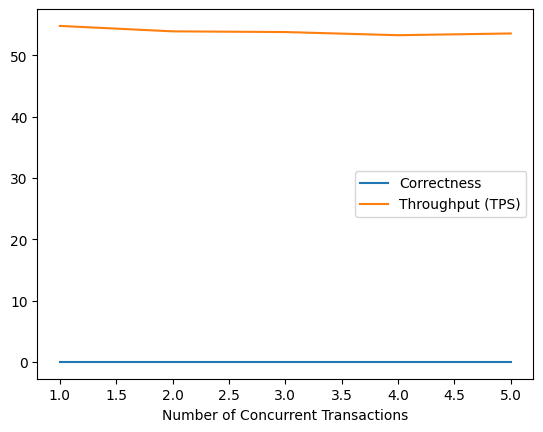

In [10]:
import matplotlib.pyplot as plt

c_values = []
tps_values = []

for concurrent_tx in range(1, 6):
    start_time = time.time()

    threads = []
    for i in range(1, 101):
        t = threading.Thread(target=run_tx_a, args=(i,))
        threads.append(t)
    for t in threads:
        t.start()
    for t in threads:
        t.join()

    end_time = time.time()
    with psycopg2.connect(dbname="postgres", user="postgres", password="6054708Fatih", host="localhost") as conn:
        with conn.cursor() as cur:
            cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=0")
            c1 = cur.fetchone()[0]
            cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=0")
            c2 = cur.fetchone()[0]
    c_value = (c1 - c2) / 100
    t = end_time - start_time
    tps = 100 / t
    c_values.append(c_value)
    tps_values.append(tps)

plt.plot(range(1, 6), c_values, label="Correctness")
plt.plot(range(1, 6), tps_values, label="Throughput (TPS)")
plt.xlabel("Number of Concurrent Transactions")
plt.legend()
plt.show()

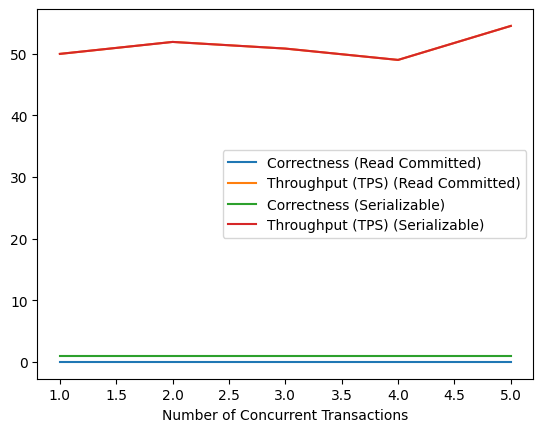

In [12]:
import matplotlib.pyplot as plt

c_values_read_committed = []
tps_values_read_committed = []
c_values_serializable = []
tps_values_serializable = []

for concurrent_tx in range(1, 6):
    start_time = time.time()

    threads = []
    for i in range(1, 101):
        t = threading.Thread(target=run_tx_a, args=(i,))
        threads.append(t)
    for t in threads:
        t.start()
    for t in threads:
        t.join()

    end_time = time.time()
    with psycopg2.connect(dbname="postgres", user="postgres", password="6054708Fatih", host="localhost") as conn:
        with conn.cursor() as cur:
            cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=0")
            c1 = cur.fetchone()[0]
            cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=0")
            c2 = cur.fetchone()[0]
    c_value = (c1 - c2) / 100
    t = end_time - start_time
    tps = 100 / t
    c_values_read_committed.append(c_value)
    tps_values_read_committed.append(tps)

    conn.set_session 
    
    with conn.cursor() as cur:
        cur.execute("SET SESSION CHARACTERISTICS AS TRANSACTION ISOLATION LEVEL SERIALIZABLE")
        cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=0")
        c1 = cur.fetchone()[0]
        for i in range(1, 101):
            run_tx_a(i)
        cur.execute("SELECT balance FROM ACCOUNTS WHERE accno=0")
        c2 = cur.fetchone()[0]

    c_value = (c1 - c2) / 100
    t = end_time - start_time
    tps = 100 / t
    c_values_serializable.append(c_value)
    tps_values_serializable.append(tps)

plt.plot(range(1, 6), c_values_read_committed, label="Correctness (Read Committed)")
plt.plot(range(1, 6), tps_values_read_committed, label="Throughput (TPS) (Read Committed)")
plt.plot(range(1, 6), c_values_serializable, label="Correctness (Serializable)")
plt.plot(range(1, 6), tps_values_serializable, label="Throughput (TPS) (Serializable)")
plt.xlabel("Number of Concurrent Transactions")
plt.legend()
plt.show()



In [ ]:
import psycopg2
import threading

def transfer_funds(thread_id):
    conn = psycopg2.connect(dbname="postgres", user="postgres", password="6054708Fatih", host="localhost")
    cur = conn.cursor()

    cur.execute("SET TRANSACTION ISOLATION LEVEL READ COMMITTED")

    for i in range(1, 101):
        cur.execute("BEGIN;")
        cur.execute("UPDATE ACCOUNTS SET balance = balance + 1 WHERE accno = %s;",(i,))
        cur.execute("UPDATE ACCOUNTS SET balance = balance - 1 WHERE accno = 0;")
        cur.execute("COMMIT;")

    conn.close()
    print(f'Thread {thread_id} completed')

threads = []
for i in range(1, 6):
    thread = threading.Thread(target=transfer_funds, args=(i,))
    thread.start()
    threads.append(thread)

for thread in threads:
    thread.join()

In [ ]:
import psycopg2

conn = psycopg2.connect(dbname="postgres", user="postgres", password="6054708Fatih", host="localhost"
)

with conn:
    with conn.cursor() as cur:
        # Create the ACCOUNTS table
        cur.execute("CREATE TABLE ACCOUNTS (accnointeger INTEGER PRIMARY KEY, balance INTEGER)")
        # Insert initial data
        cur.execute("INSERT INTO ACCOUNTS (accnointeger, balance) VALUES (0, 100)")
        for i in range(1, 101):
            cur.execute("INSERT INTO ACCOUNTS (accnointeger, balance) VALUES (%s, 0)", (i,))

In [ ]:
import time
import psycopg2
import matplotlib.pyplot as plt

conn = psycopg2.connect(dbname="postgres", user="postgres", password="6054708Fatih", host="localhost")

def run_experiment(isolation_level, concurrent_txs):
    with conn:
        with conn.cursor() as cur:
            cur.execute("SET SESSION CHARACTERISTICS AS TRANSACTION ISOLATION LEVEL " + isolation_level)
            cur.execute("SELECT balance FROM ACCOUNTS WHERE accnointeger = 0")
            c1 = cur.fetchone()[0]
            start_time = time.time()
            for i in range(concurrent_txs):
                cur.execute("BEGIN")
                for j in range(1, 101):
                    cur.execute("UPDATE ACCOUNTS SET balance = balance + 1 WHERE accnointeger = %s", (j,))
                    cur.execute("UPDATE ACCOUNTS SET balance = balance - 1 WHERE accnointeger = 0")
                cur.execute("COMMIT")
            end_time = time.time()
            cur.execute("SELECT balance FROM ACCOUNTS WHERE accnointeger = 0")
            c2 = cur.fetchone()[0]
            c_value = (c1 - c2) / 100
            t = end_time - start_time
            tps = 100 / t
            return c_value, tps

results_read_committed = []
results_serializable = []

for concurrent_txs in range(1, 6):
    c_value, tps = run_experiment("READ COMMITTED", concurrent_txs)
    results_read_committed.append((concurrent_txs, c_value, tps))

for concurrent_txs in range(1, 6):
    c_value, tps = run_experiment("SERIALIZABLE", concurrent_txs)
    results_serializable.append((concurrent_txs, c_value, tps))

x1 = [result[0] for result in results_read_committed]
y1 = [result[1] for result in results_serializable]

x2 = [result[0] for result in results_serializable]
y2 = [result[1] for result in results_serializable]

plt.figure()
plt.title("C-value for different isolation levels and number of concurrent transactions")
plt.xlabel("Number of concurrent transactions")
plt.ylabel("C-value")
plt.plot(x1, y1, label='READ COMMITTED')
plt.plot(x2, y2, label='SERIALIZABLE')
plt.legend()
plt.show()

x1 = [result[0] for result in results_read_committed]
y1 = [result[2] for result in results_read_committed]
x2 = [result[0] for result in results_serializable]
y2 = [result[2] for result in results_serializable]

plt.figure()
plt.title("TPS for different isolation levels and number of concurrent transactions")
plt.xlabel("Number of concurrent transactions")
plt.ylabel("TPS")
plt.plot(x1, y1, label='READ COMMITTED')
plt.plot(x2, y2, label='SERIALIZABLE')
plt.legend()
plt.show